## Bibiliothèque

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from resnet import resnet_layer, resnet_v1
from Distiller import Distiller_AdaIn, Distiller
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

%matplotlib inline
seed = tf.random.set_seed(10)


2022-05-11 09:14:39.757104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-11 09:14:39.757148: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Utils

In [2]:
def plot_hist(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['loss'], label = "Loss")
    plt.plot(hist.history['val_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()

## Loading cifar10 Dataset

In [3]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Creating a data augmentation process

In [4]:
print("================ Building dataGen ================")
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(x_train)

================ Building dataGen ================


## Building Resnet26 Teacher model 

In [5]:
print("============== Building Student Network Resnet8 ! =============")

teacher = teacher = tf.keras.models.load_model("Resnet26_from_logits_datagen")

============== Building Student Network Resnet8 ! =============


2022-05-11 09:14:49.741156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-11 09:14:49.741185: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-11 09:14:49.741279: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tall12): /proc/driver/nvidia/version does not exist
2022-05-11 09:14:49.741596: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Building callbacks

In [6]:
model_save = tf.keras.callbacks.ModelCheckpoint(
    "/callback/callback_save",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)



## Teacher scratch training

In [7]:
BATCH_SIZE = 32
EPOCHS = [70, 30]
lr = 0.01


Learning rate:  0.001
Epoch 1/70
1562/1562 [==============================] - 262s 165ms/step - loss: 0.4580 - sparse_categorical_accuracy: 0.9058 - val_loss: 0.5042 - val_sparse_categorical_accuracy: 0.8931
Epoch 2/70
1562/1562 [==============================] - 264s 167ms/step - loss: 0.4269 - sparse_categorical_accuracy: 0.9171 - val_loss: 0.5004 - val_sparse_categorical_accuracy: 0.8941
Epoch 3/70
1562/1562 [==============================] - 256s 162ms/step - loss: 0.4213 - sparse_categorical_accuracy: 0.9181 - val_loss: 0.5116 - val_sparse_categorical_accuracy: 0.8951
Epoch 4/70
1562/1562 [==============================] - 261s 165ms/step - loss: 0.4156 - sparse_categorical_accuracy: 0.9197 - val_loss: 0.5016 - val_sparse_categorical_accuracy: 0.8956
Epoch 5/70
1562/1562 [==============================] - 260s 164ms/step - loss: 0.4036 - sparse_categorical_accuracy: 0.9239 - val_loss: 0.4985 - val_sparse_categorical_accuracy: 0.8983
Epoch 6/70
1562/1562 [==========================

Epoch 45/70
1562/1562 [==============================] - 263s 165ms/step - loss: 0.3194 - sparse_categorical_accuracy: 0.9408 - val_loss: 0.4432 - val_sparse_categorical_accuracy: 0.9079
Epoch 46/70
1562/1562 [==============================] - 270s 169ms/step - loss: 0.3143 - sparse_categorical_accuracy: 0.9418 - val_loss: 0.4692 - val_sparse_categorical_accuracy: 0.9016
Epoch 47/70
1562/1562 [==============================] - 270s 169ms/step - loss: 0.3115 - sparse_categorical_accuracy: 0.9423 - val_loss: 0.4466 - val_sparse_categorical_accuracy: 0.9097
Epoch 48/70
1562/1562 [==============================] - 274s 172ms/step - loss: 0.3106 - sparse_categorical_accuracy: 0.9414 - val_loss: 0.4463 - val_sparse_categorical_accuracy: 0.9104
Epoch 49/70
1562/1562 [==============================] - 267s 168ms/step - loss: 0.3084 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.4455 - val_sparse_categorical_accuracy: 0.9088
Epoch 50/70
1562/1562 [==============================] - 268s 168

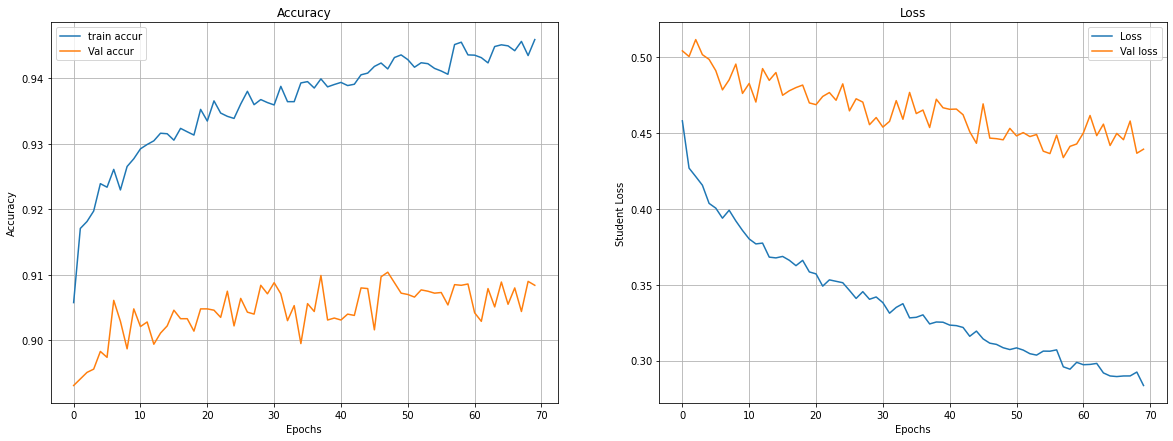

Saving model 


2022-05-11 14:22:04.793173: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Resnet26_from_logits_datagen/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Learning rate:  0.0001
Epoch 1/30
1562/1562 [==============================] - 263s 163ms/step - loss: 0.2812 - sparse_categorical_accuracy: 0.9470 - val_loss: 0.4314 - val_sparse_categorical_accuracy: 0.9098
Epoch 2/30
1562/1562 [==============================] - 261s 163ms/step - loss: 0.2807 - sparse_categorical_accuracy: 0.9473 - val_loss: 0.4309 - val_sparse_categorical_accuracy: 0.9102
Epoch 3/30
1562/1562 [==============================] - 255s 159ms/step - loss: 0.2741 - sparse_categorical_accuracy: 0.9499 - val_loss: 0.4269 - val_sparse_categorical_accuracy: 0.9093
Epoch 4/30
1562/1562 [==============================] - 253s 158ms/step - loss: 0.2728 - sparse_categorical_accuracy: 0.9495 - val_loss: 0.4339 - val_sparse_categorical_accuracy: 0.9075
Epoch 5/30
1562/1562 [==============================] - 258s 161ms/step - loss: 0.2730 - sparse_categorical_acc

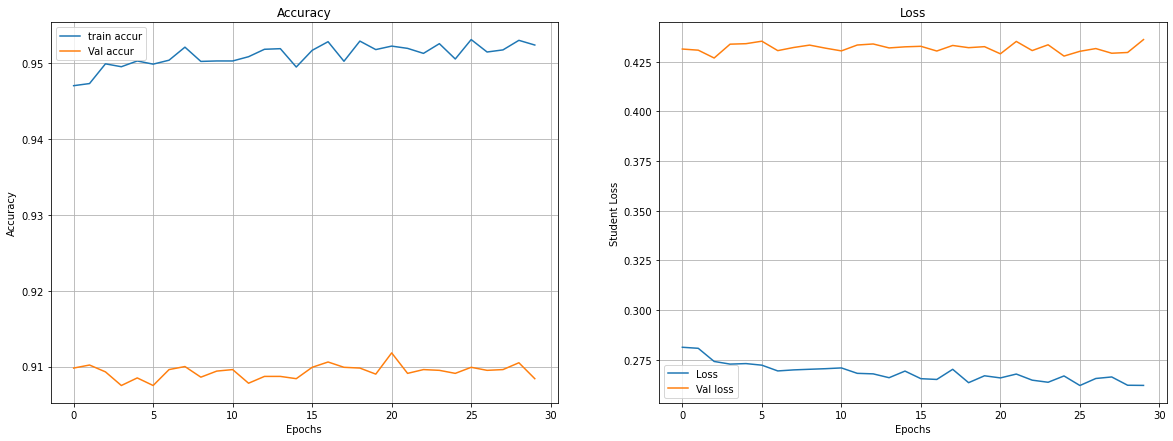

Saving model 
INFO:tensorflow:Assets written to: Resnet26_from_logits_datagen/assets
Saving Done !
Saving Weights 
Saving Done !

End !


In [8]:
for epoch in EPOCHS:
    lr = lr/10 
    print("Learning rate: ", lr)
    NAME = f"Resnet26_from_logits_datagen_lr_{lr}"
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs/{NAME}", 
                                             histogram_freq = 1)

    teacher.compile(
      optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # Train and evaluate on data.
    hist = teacher.fit(datagen.flow(x_train, y_train, 
          batch_size = BATCH_SIZE),
          epochs = epoch,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =64,
          use_multiprocessing= True,
          callbacks = [tensorboard],
          )


    teacher.evaluate(x_test, y_test)
    print("")

    print(" =============== History Plot ===============")
    plot_hist(hist, f"Resnet26_from_logits_datagen_lr_{lr}.png")


    print("Saving model ")
    teacher.save(f"Resnet26_from_logits_datagen")
    print("Saving Done !")

    print("Saving Weights ")
    teacher.save_weights(f"Resnet26_from_logits_datagen.h5")
    print("Saving Done !")
    print("")

    print("End !")